## Imports

In [1]:
from __future__ import division
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import math
from matplotlib import cm
import matplotlib as mpl
%matplotlib inline

## Class of constants

In [2]:
class Constants(object):
    """Here we simply define a class that contains the constants necessary within the problem."""
    
    def __init__(self, lambda_hs_0 = 0, lambda_s_0 = 0.01, lambda_h_0 = 0.13):
        
        # Initial values at scale mt
        self.g_0 = 0.64
        self.g_pr_0 = 0.35  
        self.g3_0 = 1.16  
        self.yt_0 = 0.93  
        self.mh = 125  # GeV
        self.lambda_h_0 = lambda_h_0
        
        # Change the sign of lambda_s(mt) depending on the value of lambda_h(mt)
        if (self.lambda_h_0 - 0.13) >= 0:
            self.lambda_s_0 = lambda_s_0
        else:
            self.lambda_s_0 = -lambda_s_0
        
        # Calculate lambda_hs(mt) according to Equation (10) of [Lebedev 2012]
        self.lambda_hs_0 = np.sqrt(4 * self.lambda_s_0 * (self.lambda_h_0 - 0.13))

## Class for solving the system of RGEs at a given list of scales

In [3]:
class Solver(object):
    """This class solves a system of equations for calculating the evolution of the Higgs self-coupling"""
    
    def __init__(self, t, constants):
        self.constants = constants
        self.t = t
        
    def dsdt(self, s, t):
        
        lambda_h, lambda_hs, lambda_s, yt, g, g_pr, g3 = s

        lambda_h_prime = (24 * lambda_h**2 - 6 * yt**4 + 3 * (2 * g**4 + (g**2 + g_pr**2)**2)/8 + (-9 * g**2 - 3 * g_pr**2 + 12 * yt**2) * lambda_h + lambda_hs**2/2)/(16 * np.pi**2)  
        lambda_hs_prime = (4 * lambda_hs**2 + 12 * lambda_h * lambda_hs - 3 * (3 * g**2 + g_pr**2) * lambda_hs/2 + 6 * yt**2 * lambda_hs + 6 * lambda_s * lambda_hs)/(16 * np.pi**2)  
        lambda_s_prime = (2 * lambda_hs**2 + 18 * lambda_s**2)/(16 * np.pi**2)  
        yt_prime = (9 * yt**2/2 - 17 * g_pr**2/12 - 9 * g**2/4 - 8 * g3**2) * yt/(16 * np.pi**2)  
        g_prime = (-19 * g**3/6)/(16 * np.pi**2)  
        g_pr_prime = (41 * g_pr**3/6)/(16 * np.pi**2)  
        g3_prime = (-7 * g3**3)/(16 * np.pi**2)  

        dsdt = [lambda_h_prime, lambda_hs_prime, lambda_s_prime, yt_prime, g_prime, g_pr_prime, g3_prime]
        return dsdt
       
    def solve(self):
        lambda_h_0 = self.constants.lambda_h_0
        lambda_hs_0 = self.constants.lambda_hs_0
        lambda_s_0 = self.constants.lambda_s_0
        yt_0 = self.constants.yt_0
        g_0 = self.constants.g_0
        g_pr_0 = self.constants.g_pr_0
        g3_0 = self.constants.g3_0
        s0 = [lambda_h_0, lambda_hs_0, lambda_s_0, yt_0, g_0, g_pr_0, g3_0]
        sol = odeint(self.dsdt, s0, self.t)
        return sol

In [4]:
def func(a, row):
    '''Interpolating function'''
    p = a[:,row]
    return lambda t: np.interp(t, tlist, p)

## Results

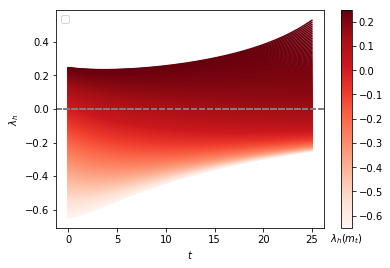

In [5]:
tlist = np.linspace(0, 25, 10001)

# Bounds on lambda_h(mt) from ATLAS
lambda_SM_0 = 0.13
lambda_h_0_min = -5.0 * lambda_SM_0
lambda_h_0_max = 1.9 * lambda_SM_0  # 12.0 * lambda_SM_0
lambda_h_0_list = np.linspace(lambda_h_0_min, lambda_h_0_max, 1000)

mycmap = cm.Reds
    
# Solve the system of equations for all values of lambda_h_0 between the bounds
for j, lambda_h_0_item in enumerate(lambda_h_0_list):
    C = Constants(lambda_h_0 = lambda_h_0_item) 
    sol = Solver(tlist, constants = C).solve()
    lambda_h = func(sol, 0)
    lambda_hs = func(sol, 1)
    lambda_s = func(sol, 2)
    yt = func(sol, 3)
    g = func(sol, 4)
    g_pr = func(sol, 5)
    g3 = func(sol, 6)       
        
    norm = plt.Normalize(vmin = lambda_h_0_min, vmax = lambda_h_0_max)
    plt.plot(tlist, lambda_h(tlist), color = mycmap(norm(lambda_h_0_item)))            
    plt.axhline(y = 0, linestyle='dashed', c = 'grey')
    plt.ylabel(r'$\lambda_h$')
    plt.xlabel('$t$')
        
sm = plt.cm.ScalarMappable(cmap = mycmap, norm = plt.Normalize(vmin = lambda_h_0_min, vmax = lambda_h_0_max))
sm.set_array(mycmap(lambda_h_0_list))
cb = plt.colorbar(sm)
cb.ax.set_xlabel(r'$\lambda_{h}(m_t)$')
plt.legend()
plt.savefig('lambda_h_bounds+lambda_s_0=' + str(C.lambda_s_0) + '.pdf', bbox_inches="tight")
plt.show()

In [6]:
#tlist = np.linspace(0, 25, 10001)

#C = Constants(lambda_hs_0 = 0.045, lambda_s_0 = 20.0, lambda_h_0 = 1.56) 
#sol = Solver(tlist, constants = C).solve()
#lambda_h = func(sol, 0)
#lambda_hs = func(sol, 1)
#lambda_s = func(sol, 2)
#yt = func(sol, 3)
#g = func(sol, 4)
#g_pr = func(sol, 5)
#g3 = func(sol, 6)       
        
#plt.plot(tlist, lambda_h(tlist))            
#plt.axhline(y = 0, linestyle='dashed', c = 'grey')
#plt.ylabel(r'$\lambda_h$')
#plt.xlabel('$t$')
#plt.show()

#plt.plot(tlist, lambda_hs(tlist))            
#plt.axhline(y = 0, linestyle='dashed', c = 'grey')
#plt.ylabel(r'$\lambda_{hs}$')
#plt.xlabel('$t$')
#plt.show()

#plt.plot(tlist, lambda_s(tlist))            
#plt.axhline(y = 0, linestyle='dashed', c = 'grey')
#plt.ylabel(r'$\lambda_{s}$')
#plt.xlabel('$t$')
#plt.show()